<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural

## Sentiment Analysis usando BERT y transfer learning

- Leandro Saraco
- Octubre 2024


In [1]:
import tensorflow
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from transformers import TFBertModel

2024-10-17 12:41:53.194368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 12:41:53.216475: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-17 12:41:53.222925: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-17 12:41:53.239750: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-17 12:41:54.376384: W tensorflow/compiler/tf2

### Definiendo modelo

In [2]:
# Para el primer modelo
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

# Para el segundo modelo usando dos capas fully connected
bert_model_2 = TFBertModel.from_pretrained("bert-base-uncased")

2024-10-17 12:41:57.323560: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you a

In [3]:
max_length = 180
output_shape = 3

In [4]:
bert_model.bert.trainable = False

input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')
attention_mask = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='attention_mask')

outputs = bert_model(input_ids, attention_mask=attention_mask)

pooled_output = outputs.pooler_output

x = tensorflow.keras.layers.Dropout(0.2)(pooled_output)
output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(x)

model = tensorflow.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',tensorflow.keras.metrics.F1Score(average='macro')])

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 180)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 180)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 180, 7                                       

In [3]:
def plot_train_metrics(history):
    epoch_count = range(1, len(history.history['accuracy']) + 1)
    sns.lineplot(x=epoch_count,  y=history.history['accuracy'], label='train')
    sns.lineplot(x=epoch_count,  y=history.history['val_accuracy'], label='valid')
    plt.show()

### Datos
Utilizaremos como dataset críticas de Google Apps en formato csv.

In [7]:
# # Descargar la carpeta de dataset - DESCOMENTAR si no están descargados los archivos
# !curl -L -o 'apps.csv' 'https://drive.google.com/u/0/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV&export=download&confirm=t'
# !curl -L -o 'reviews.csv' 'https://drive.google.com/u/0/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv&export=download&confirm=t'

In [5]:
import pandas as pd
# Armar el dataset
df = pd.read_csv('reviews.csv')
df.sample(5)

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
13475,chi mak,https://lh3.googleusercontent.com/a-/AOh14GgHt...,Do not download this app. There are Ads everyt...,1,0,NaN,2020-02-27 14:25:28,"Hi, we avoided this solution for as long as it...",2020-02-28 09:27:12,newest,com.appgenix.bizcal
2085,Susan Petrie,https://lh3.googleusercontent.com/-7Q2cI4hvC6A...,Only began using it but seems intuitive to use...,4,0,15.0.3,2019-11-25 11:56:58,NaN,NaN,most_relevant,com.todoist
6803,Rod Goree,https://lh3.googleusercontent.com/a-/AOh14Gi_K...,Liked the setup so much that I quickly became ...,4,10,1.5.11,2020-02-18 17:33:24,NaN,NaN,most_relevant,com.oristats.habitbull
3713,Ian McClaskey,https://lh3.googleusercontent.com/a-/AOh14Gict...,This app is completely unusable on my Note10+ ...,1,0,NaN,2020-02-24 21:02:27,"Hi Ian, sorry about that, the issue with the c...",2020-02-27 23:54:19,newest,com.habitrpg.android.habitica
11760,GIRISH. K GIRI,https://lh3.googleusercontent.com/a-/AOh14Ghh7...,Nice app,4,0,2.6.5,2019-09-10 18:54:37,NaN,NaN,newest,com.gmail.jmartindev.timetune


In [6]:
print("Cantidad de críticas:", len(df))

Cantidad de críticas: 15746


/tmp/ipykernel_2991223/1617978975.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df.score,palette='Set2')


<Axes: xlabel='score', ylabel='count'>

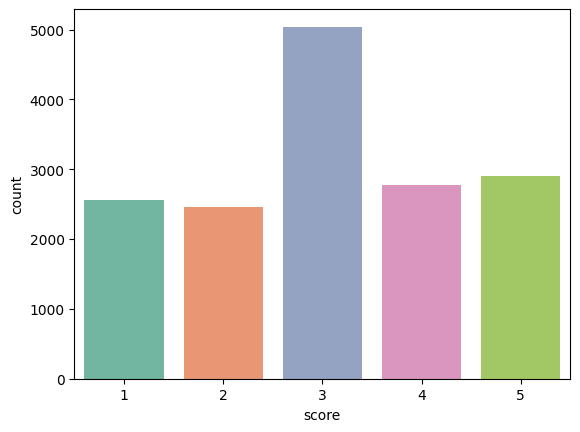

In [7]:
# ¿Cómo están balanceados los datos?
sns.countplot(x=df.score,palette='Set2')

## Limpieza de datos

In [9]:
# Balancear los datos
df['sentiment'] = df.score.apply(lambda x: 0 if x <=2 else 1 if x == 3 else 2)
class_names = ['negative', 'neutral', 'positive']
df.sample(5)

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
11400,Avis Ejerenwa,https://lh3.googleusercontent.com/a-/AOh14GgWy...,"This is a very cool app, and thus have the rat...",3,0,2.7.1,2020-02-03 16:55:04,"Hi, please contact us at timetuneapp@gmail.com...",2020-02-03 19:25:44,newest,com.gmail.jmartindev.timetune,1
12788,Connie Mascelli,https://lh3.googleusercontent.com/-t12_w2PhwNk...,easy to use,3,0,2.0.0,2019-12-16 12:58:26,"Hi Connie, really glad you're finding my app u...",2019-12-16 13:44:23,newest,com.tasks.android,1
8456,Lu La,https://lh3.googleusercontent.com/a-/AOh14Ghc2...,My prior app isnt any more and they automatica...,1,2,2.10.147,2020-03-11 07:25:35,NaN,NaN,most_relevant,com.microsoft.todos,0
7329,Tuukka Rinkinen,https://lh3.googleusercontent.com/a-/AOh14GhRZ...,"Ok concept, but just takes way too much effort...",2,0,2.12.0,2020-03-27 21:09:27,Thanks for the feedback.\nI'll try to make app...,2020-03-30 17:39:10,newest,com.levor.liferpgtasks,0
15206,A Google user,https://lh3.googleusercontent.com/EGemoI2NTXmT...,helpful but not too much,3,0,NaN,2017-05-22 07:04:00,NaN,NaN,newest,com.appxy.planner,1


/tmp/ipykernel_2991223/1249906356.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df.sentiment,palette='Set2')
/tmp/ipykernel_2991223/1249906356.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names)


[Text(0, 0, 'negative'), Text(1, 0, 'neutral'), Text(2, 0, 'positive')]

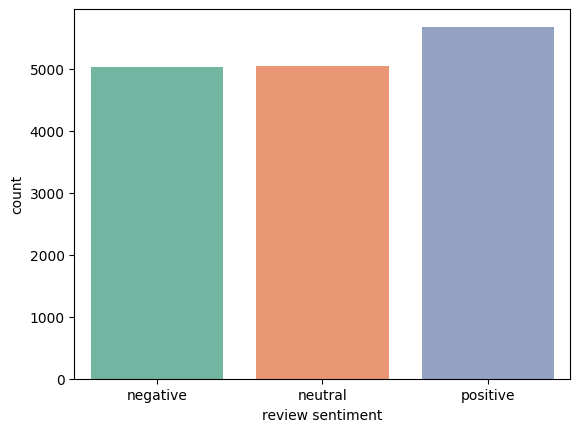

In [10]:
ax = sns.countplot(x=df.sentiment,palette='Set2')
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

In [11]:
sentences = df['content'].values
print("sentences shape:", sentences.shape)
sentences[:3]

sentences shape: (15746,)


array(["Update: After getting a response from the developer I would change my rating to 0 stars if possible. These guys hide behind confusing and opaque terms and refuse to budge at all. I'm so annoyed that my money has been lost to them! Really terrible customer experience. Original: Be very careful when signing up for a free trial of this app. If you happen to go over they automatically charge you for a full years subscription and refuse to refund. Terrible customer experience and the app is just OK.",
       'Used it for a fair amount of time without any problems. Suddenly then asked me to create an account or log using Google or FB. I used my Google one only to discover everything was gone!',
       "Your app sucks now!!!!! Used to be good but now doesn't update until I physically open it up and then close it then scroll and then it finally shows what I want to put on the list!!!!!! And I FRIGGEN paid for this garbage!!!!!!!"],
      dtype=object)

Median: 139.0


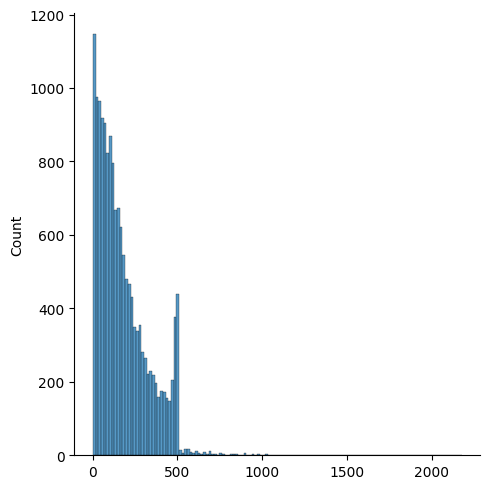

In [12]:
sentence_lens = []

for sentence in sentences:
  sentence_lens.append(len(sentence))

print("Median:", np.median(sentence_lens))
sns.displot(sentence_lens)

In [13]:
from tensorflow.keras.utils import to_categorical

In [14]:
y = df['sentiment'].values
print("y shape:", y.shape)
y = to_categorical(y)
print(y[:3])
output_shape = y.shape[1]
print("output shape:", output_shape)

y shape: (15746,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
output shape: 3


## 1 - Data generator


In [15]:
from transformers import InputExample, InputFeatures  # Métodos para transformar el dataset
from transformers import BertTokenizer
import numpy as np

In [16]:
# Muy importante que para tensorflow los modelos Bert deben empezar con "TF"
# de lo contrario estaremos utilizando un modelo para pytorch

# Descargamos el modelo base de BERT más liviano y su correspondiente tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [17]:
# Del dataset original accederemos a los datos por índices (idx)
# mezclados aleatoriamente
from sklearn.model_selection import train_test_split
indices = np.arange(len(sentences))
idx_train_val, idx_test = train_test_split(indices, test_size=0.2, random_state=42)
idx_train, idx_val = train_test_split(idx_train_val, test_size=0.2, random_state=42)

In [18]:
print(idx_train.shape[0], idx_val.shape[0], idx_test.shape[0])

10076 2520 3150


In [19]:

def convert_data_to_examples(text, labels, idx_train, idx_val):
    # Armamos un "InputExample" para los datos de entrenamiento y validación
    train_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i],
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_train]

    validation_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i],
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_val]

    return train_InputExamples, validation_InputExamples


def convert_examples_to_tf_dataset(examples, bert_tokenizer, max_length=512):
    # Transformamos los datos de entrada en tensorres de:
    # input_ids --> token id
    # attention_mask
    # token type
    features = []

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = bert_tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=False,
            return_attention_mask=True,
            padding='max_length', # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, attention_mask = (input_dict["input_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, label=e.label
            )
        )

    def gen():
    # Función generadora para no levantar todos los datos en un instante
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                },
                f.label,
            )

    return tensorflow.data.Dataset.from_generator(
        # Tensorflow dataset generator (basado en el generador y en el esquema de datos definido)
        gen,
        ({"input_ids": tensorflow.int32, "attention_mask": tensorflow.int32}, tensorflow.float32),
        (
            {
                "input_ids": tensorflow.TensorShape([None]),
                "attention_mask": tensorflow.TensorShape([None]),
            },
            tensorflow.TensorShape([output_shape]),
        ),
    )

In [20]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(sentences, y, idx_train, idx_val)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), bert_tokenizer, max_length=max_length)
# shuffle 100 --> mezcla los datos y los lee a de 100 unidades
# batch 32 --> ejecuta una epoca de entrenamiento de a 32 unidades
train_data = train_data.shuffle(100).batch(32)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), bert_tokenizer, max_length=max_length)
validation_data = validation_data.batch(32)

In [21]:
pred_sentences = [sentences[i] for i in idx_test]
tf_batch = bert_tokenizer(pred_sentences, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

In [22]:
X_test = [tf_batch['input_ids'],
          tf_batch['attention_mask']]

In [23]:
y_test = y[idx_test]

## 2 - BERT multiclass classification

In [31]:
history1 = model.fit(train_data, epochs=8, validation_data=validation_data)

Epoch 1/8


    315/Unknown - 1874s 6s/step - loss: 1.1163 - accuracy: 0.3951 - f1_score: 0.3900

2024-10-16 11:41:30.424130: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-16 11:48:18.303474: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


315/315 [==============================] - 2282s 7s/step - loss: 1.1163 - accuracy: 0.3951 - f1_score: 0.3900 - val_loss: 1.0207 - val_accuracy: 0.4492 - val_f1_score: 0.3732
Epoch 2/8
315/315 [==============================] - 2280s 7s/step - loss: 1.0360 - accuracy: 0.4634 - f1_score: 0.4550 - val_loss: 0.9603 - val_accuracy: 0.5413 - val_f1_score: 0.4780
Epoch 3/8
315/315 [==============================] - 2234s 7s/step - loss: 0.9993 - accuracy: 0.4993 - f1_score: 0.4882 - val_loss: 0.9488 - val_accuracy: 0.5385 - val_f1_score: 0.4540
Epoch 4/8
315/315 [==============================] - 2226s 7s/step - loss: 0.9761 - accuracy: 0.5193 - f1_score: 0.5090 - val_loss: 0.9457 - val_accuracy: 0.5508 - val_f1_score: 0.4523
Epoch 5/8
315/315 [==============================] - 2227s 7s/step - loss: 0.9686 - accuracy: 0.5159 - f1_score: 0.5057 - val_loss: 0.8930 - val_accuracy: 0.5722 - val_f1_score: 0.5514
Epoch 6/8
315/315 [==============================] - 2226s 7s/step - loss: 0.9427 - a

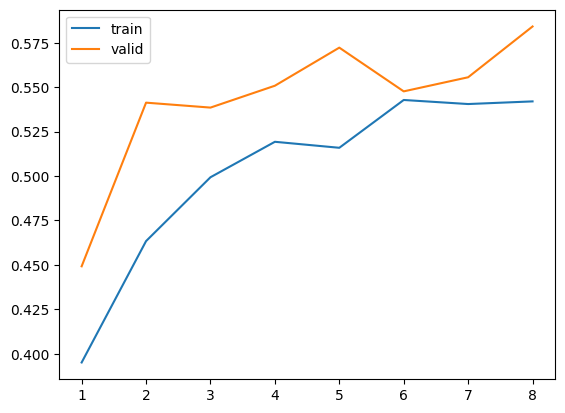

In [32]:
plot_train_metrics(history1)

In [33]:
y_hat_prob = model.predict(X_test)
y_hat_prob[:3]

99/99 [==============================] - 505s 5s/step


array([[0.4271959 , 0.43560147, 0.13720249],
       [0.36863434, 0.38839856, 0.24296708],
       [0.1742802 , 0.44935337, 0.37636644]], dtype=float32)

In [34]:
y_hat = np.argmax(y_hat_prob, axis=1)

In [35]:
# Calcular la exactitud (accuracy)
scores = model.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 506s 5s/step - loss: 0.8890 - accuracy: 0.5752 - f1_score: 0.5712


0.5752381086349487

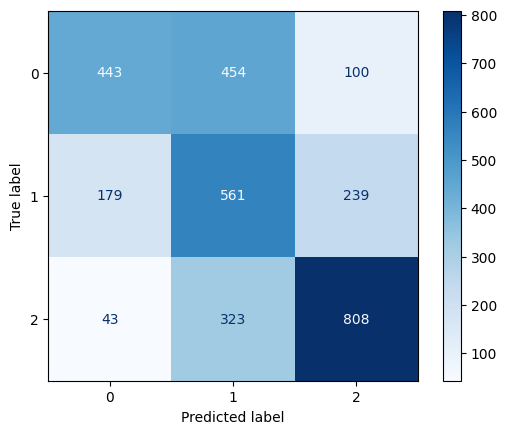

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)
unique_labels = np.unique(y_test.argmax(axis=1))
cmd = ConfusionMatrixDisplay(cm, display_labels=unique_labels)
cmd.plot(cmap=plt.cm.Blues)
plt.show()

## 3 - BERT Fine tuning

In [37]:
from tensorflow import optimizers

model2 = model

# Colocar todas las layers como entrenables
for layer in model.layers:
  layer.trainable = True

# Como es fine tunning se recomiendo utiliza al menos un learning rate 100 veces
# menor
model2.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 180)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 180)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 180, 7                                       

In [38]:
history2 = model2.fit(train_data, epochs=8, validation_data=validation_data)

Epoch 1/8


    315/Unknown - 5242s 17s/step - loss: 0.7487 - accuracy: 0.6535

2024-10-16 18:00:45.569662: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


315/315 [==============================] - 5653s 18s/step - loss: 0.7487 - accuracy: 0.6535 - val_loss: 0.6648 - val_accuracy: 0.7056
Epoch 2/8
315/315 [==============================] - 5679s 18s/step - loss: 0.6027 - accuracy: 0.7303 - val_loss: 0.6328 - val_accuracy: 0.7214
Epoch 3/8
315/315 [==============================] - 6541s 21s/step - loss: 0.4781 - accuracy: 0.8025 - val_loss: 0.6492 - val_accuracy: 0.7560
Epoch 4/8
315/315 [==============================] - 6135s 19s/step - loss: 0.3333 - accuracy: 0.8659 - val_loss: 0.7084 - val_accuracy: 0.7802
Epoch 5/8
315/315 [==============================] - 5925s 19s/step - loss: 0.2137 - accuracy: 0.9179 - val_loss: 0.7781 - val_accuracy: 0.8016
Epoch 6/8
315/315 [==============================] - 5885s 19s/step - loss: 0.1517 - accuracy: 0.9430 - val_loss: 0.8502 - val_accuracy: 0.8163
Epoch 7/8
315/315 [==============================] - 5883s 19s/step - loss: 0.1183 - accuracy: 0.9533 - val_loss: 0.9570 - val_accuracy: 0.8099
Ep

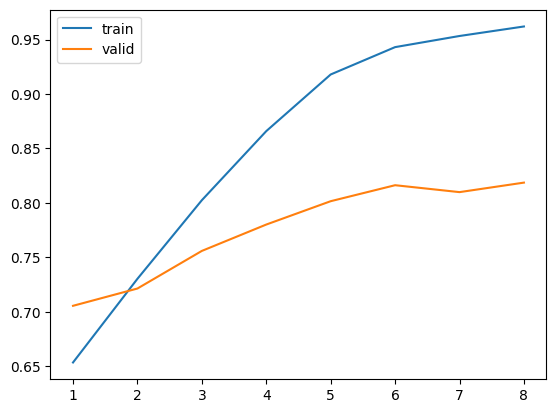

In [39]:
plot_train_metrics(history2)

In [40]:
y_hat_prob2 = model2.predict(X_test)
y_hat_prob2[:3]

99/99 [==============================] - 510s 5s/step


array([[1.5247336e-01, 8.2454044e-01, 2.2986177e-02],
       [9.9905938e-01, 9.4048667e-04, 1.7029151e-07],
       [1.5644053e-03, 9.9144924e-01, 6.9863419e-03]], dtype=float32)

In [41]:
y_hat2 = np.argmax(y_hat_prob2, axis=1)

In [42]:
# Calcular la exactitud (accuracy)
scores = model2.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 510s 5s/step - loss: 1.0158 - accuracy: 0.8181


0.8180952668190002

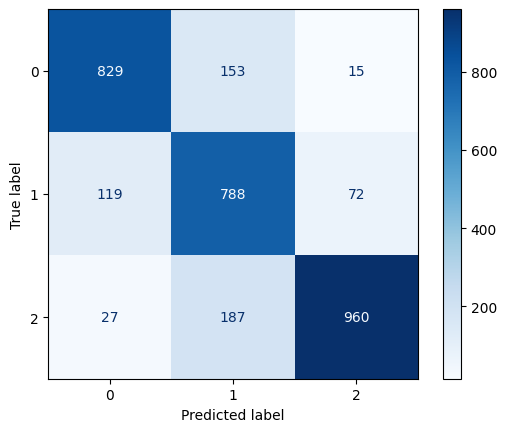

In [43]:
cm = confusion_matrix(y_test.argmax(axis=1), y_hat2)
unique_labels = np.unique(y_test.argmax(axis=1))
cmd = ConfusionMatrixDisplay(cm, display_labels=unique_labels)
cmd.plot(cmap=plt.cm.Blues)
plt.show()

## Salvar el modelo

In [52]:
model.save_weights('bert_weights_before_fine_tunning.h5')
model2.save_weights('bert_weights.h5')

In [45]:
# Descargar los pesos a nuestra PC - Descomentar esto solo en caso de usar google Colab
# Solo es necesario si se desea repetir el uso de este modelo en el futuro
# from google.colab import files
# files.download('bert_weights.h5')

## Levantar el modelo

In [46]:
LOAD_MODEL = False

if LOAD_MODEL:

    bert_model3 = TFBertModel.from_pretrained("bert-base-uncased")

    input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')

    # attention_mask - is a binary mask which tells BERT which tokens to attend and which not to attend.
    # Encoder will add the 0 tokens to the some sequence which smaller than MAX_SEQUENCE_LENGTH,
    # and attention_mask, in this case, tells BERT where is the token from the original data and where is 0 pad token:
    attention_mask = tensorflow.keras.layers.Input((max_length,), dtype=tensorflow.int32, name='attention_mask')

    # Get the pooled_output (embedding que representa toda la entrada)
    output = bert_model3([input_ids, attention_mask])[1]

    # We can also add dropout as regularization technique:
    output = tensorflow.keras.layers.Dropout(rate=0.2)(output)

    # Se puede agregar más capas Densas en el medio si se desea

    # Provide number of classes to the final layer:
    output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(output)

    # Final model:
    model3 = tensorflow.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)

In [47]:
if LOAD_MODEL:
    model3.load_weights('bert_weights.h5')
else:
    model3 = model2 #Reusar el modelo de la etapa anterior

## Ensayo

In [48]:
text = "I love this app!"

#tf_batch = bert_tokenizer(text, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, # truncates if len(s) > max_length
    return_token_type_ids=False,
    return_attention_mask=True,
    pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
    truncation=True,
    return_tensors='tf'
)

print("Inputs ids:", tf_batch['input_ids'])
print("Attention mask:", tf_batch['attention_mask'])

Inputs ids: tf.Tensor(
[[  101  1045  2293  2023 10439   999   102     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0  

/home/idk/git/ceia/nlp_fiuba/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2829: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [49]:
X_ensayo = [tf_batch['input_ids'],
          tf_batch['attention_mask']]

In [50]:
y_prob_ensayo = model3.predict(X_ensayo)
y_prob = np.argmax(y_prob_ensayo, axis=1)
print("Clasificación:", class_names[int(y_prob)])

1/1 [==============================] - 0s 484ms/step
Clasificación: positive


/tmp/ipykernel_717006/2431970867.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Clasificación:", class_names[int(y_prob)])


- Vemos que el modelo clasifica correctamente "I love this app!" como positiva

## Alternativa: agregando otra capa fully connected

In [4]:
bert_model_2.bert.trainable = False

input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')
attention_mask = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='attention_mask')

outputs = bert_model_2 (input_ids, attention_mask=attention_mask)

pooled_output = outputs.pooler_output

# Primera capa dropout + FC
dp1 = tensorflow.keras.layers.Dropout(0.2)(pooled_output)
x1 = tensorflow.keras.layers.Dense(64, activation='relu')(dp1)

# Segunda capa dropout + FC
dp2 = tensorflow.keras.layers.Dropout(0.1)(x1)
x2 = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(dp2)

model_double_fc = tensorflow.keras.Model(inputs=[input_ids, attention_mask], outputs=x2)

model_double_fc.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',tensorflow.keras.metrics.F1Score(average='macro')])

### Entrenamiento


In [ ]:
history_double_fc = model_double_fc.fit(train_data, epochs=8, validation_data=validation_data)

Epoch 1/8


I0000 00:00:1729185682.192193     113 service.cc:145] XLA service 0x78247471ac80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729185682.192242     113 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729185682.192245     113 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1729185682.398173     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


315/315 [==============================] - 224s 560ms/step - loss: 1.0948 - accuracy: 0.3878 - f1_score: 0.3503 - val_loss: 1.0394 - val_accuracy: 0.5119 - val_f1_score: 0.4154
Epoch 2/8
315/315 [==============================] - 169s 537ms/step - loss: 1.0283 - accuracy: 0.4618 - f1_score: 0.4165 - val_loss: 0.9904 - val_accuracy: 0.4607 - val_f1_score: 0.3893
Epoch 3/8
315/315 [==============================] - 169s 538ms/step - loss: 0.9873 - accuracy: 0.4945 - f1_score: 0.4588 - val_loss: 0.9673 - val_accuracy: 0.4929 - val_f1_score: 0.4172
Epoch 4/8
315/315 [==============================] - 169s 537ms/step - loss: 0.9655 - accuracy: 0.5117 - f1_score: 0.4815 - val_loss: 0.9363 - val_accuracy: 0.5413 - val_f1_score: 0.4864
Epoch 5/8
315/315 [==============================] - 169s 537ms/step - loss: 0.9648 - accuracy: 0.5128 - f1_score: 0.4712 - val_loss: 0.9158 - val_accuracy: 0.5401 - val_f1_score: 0.4994
Epoch 6/8
315/315 [==============================] - 170s 538ms/step - loss

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

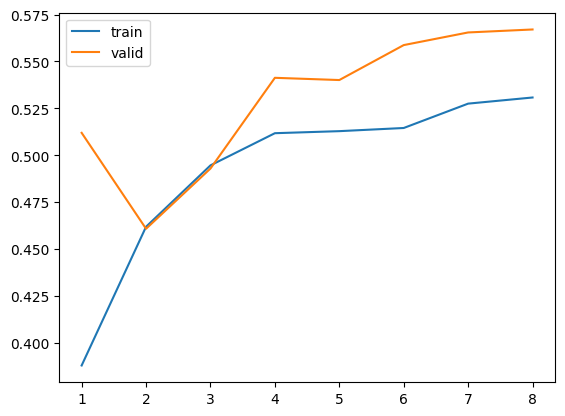

In [ ]:
plot_train_metrics(history_double_fc)

### Métricas

Evaluación

In [ ]:
# Obtener probabilidades usando el nuevo modelo
y_hat_prob = model_double_fc.predict(X_test)
y_hat_prob[:3]
y_hat = np.argmax(y_hat_prob, axis=1)

# Calcular la exactitud (accuracy)
scores = model_double_fc.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 51s 408ms/step - loss: 0.8932 - accuracy: 0.5778 - f1_score: 0.5166


0.5777778029441833

Matriz de confusión

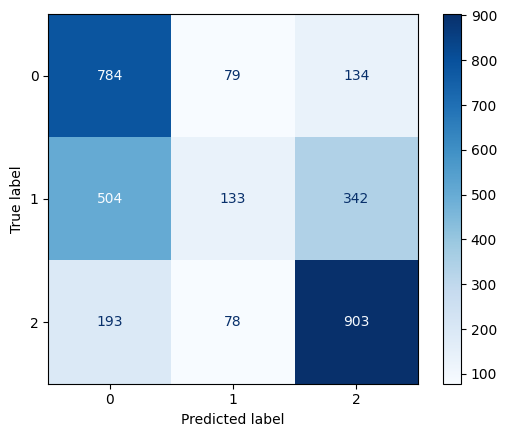

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)
unique_labels = np.unique(y_test.argmax(axis=1))
cmd = ConfusionMatrixDisplay(cm, display_labels=unique_labels)
cmd.plot(cmap=plt.cm.Blues)
plt.show()

### Fine tuning

In [ ]:
from tensorflow import optimizers

model_double_fc_FT = model_double_fc

# Colocar todas las layers como entrenables
for layer in model_double_fc_FT.layers:
  layer.trainable = True

# Como es fine tunning se recomiendo utiliza al menos un learning rate 100 veces
# menor
model_double_fc_FT.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_double_fc_FT.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 180)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 180)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 180, 7                                       

In [ ]:
history_double_fc_FT = model_double_fc_FT.fit(train_data, epochs=8, validation_data=validation_data)

Epoch 1/8
315/315 [==============================] - 459s 1s/step - loss: 0.7758 - accuracy: 0.6372 - val_loss: 0.6967 - val_accuracy: 0.6722
Epoch 2/8
315/315 [==============================] - 390s 1s/step - loss: 0.6618 - accuracy: 0.6968 - val_loss: 0.6522 - val_accuracy: 0.7111
Epoch 3/8
315/315 [==============================] - 390s 1s/step - loss: 0.5695 - accuracy: 0.7469 - val_loss: 0.6578 - val_accuracy: 0.7401
Epoch 4/8
315/315 [==============================] - 390s 1s/step - loss: 0.4646 - accuracy: 0.8069 - val_loss: 0.6554 - val_accuracy: 0.7683
Epoch 5/8
315/315 [==============================] - 389s 1s/step - loss: 0.3609 - accuracy: 0.8592 - val_loss: 0.7256 - val_accuracy: 0.7817
Epoch 6/8
315/315 [==============================] - 390s 1s/step - loss: 0.2576 - accuracy: 0.9013 - val_loss: 0.8153 - val_accuracy: 0.7913
Epoch 7/8
315/315 [==============================] - 389s 1s/step - loss: 0.1897 - accuracy: 0.9293 - val_loss: 0.7727 - val_accuracy: 0.8000
Epoch 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

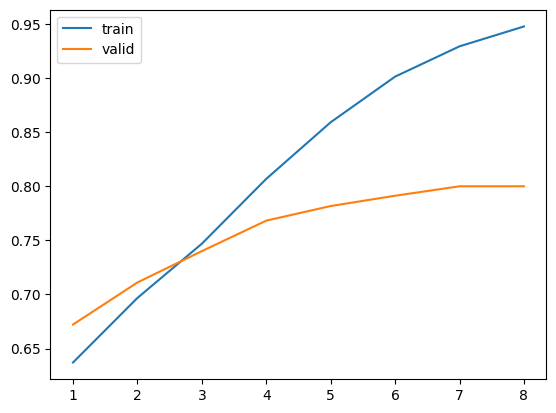

In [ ]:
plot_train_metrics(history_double_fc_FT)

In [ ]:
# Obtener probabilidades usando el nuevo modelo con fine tuning
y_hat_prob = model_double_fc_FT.predict(X_test)
y_hat_prob[:3]
y_hat = np.argmax(y_hat_prob, axis=1)

# Calcular la exactitud (accuracy)
scores = model_double_fc_FT.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 51s 409ms/step - loss: 0.9193 - accuracy: 0.8190


0.8190476298332214

Matriz de confusión

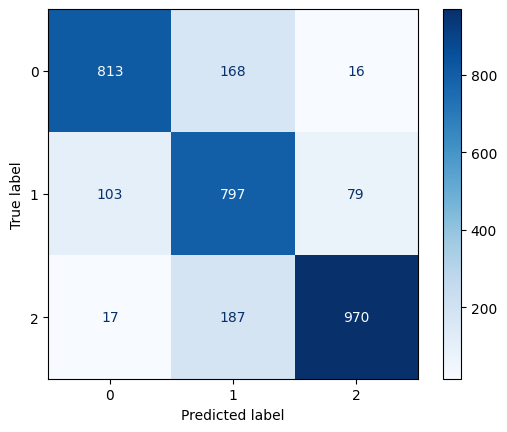

In [ ]:
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)
unique_labels = np.unique(y_test.argmax(axis=1))
cmd = ConfusionMatrixDisplay(cm, display_labels=unique_labels)
cmd.plot(cmap=plt.cm.Blues)
plt.show()

Guardado del modelo

In [ ]:
model_double_fc.save_weights('bert_weights_2_FC_before_fine_tunning.h5')
model_double_fc_FT.save_weights('bert_weights_2_FC.h5')

### Ensayo

In [ ]:
text = "I love this app!"

#tf_batch = bert_tokenizer(text, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, # truncates if len(s) > max_length
    return_token_type_ids=False,
    return_attention_mask=True,
    pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
    truncation=True,
    return_tensors='tf'
)

print("Inputs ids:", tf_batch['input_ids'])
print("Attention mask:", tf_batch['attention_mask'])

In [ ]:
X_ensayo = [tf_batch['input_ids'],
          tf_batch['attention_mask']]

In [ ]:
y_prob_ensayo = model_double_fc_FT.predict(X_ensayo)
y_prob = np.argmax(y_prob_ensayo, axis=1)
print("Clasificación:", class_names[int(y_prob)])

1/1 [==============================] - 0s 68ms/step
Clasificación: positive


/tmp/ipykernel_30/733052191.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Clasificación:", class_names[int(y_prob)])


## Comparación de modelos

In [ ]:
def plot_train_metrics_2(history1,history2):
    epoch_count = range(1, len(history1.history['accuracy']) + 1)
    # History 1
    sns.lineplot(x=epoch_count,  y=history1.history['accuracy'], label='Test Accuracy (modelo 1)')
    sns.lineplot(x=epoch_count,  y=history1.history['val_accuracy'], label='Validation Accuracy  (modelo 1)')
    # History 2
    sns.lineplot(x=epoch_count,  y=history2.history['accuracy'], label='Test Accuracy  (modelo 2)')
    sns.lineplot(x=epoch_count,  y=history2.history['val_accuracy'], label='Validation Accuracy  (modelo 2)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Test vs Validation Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

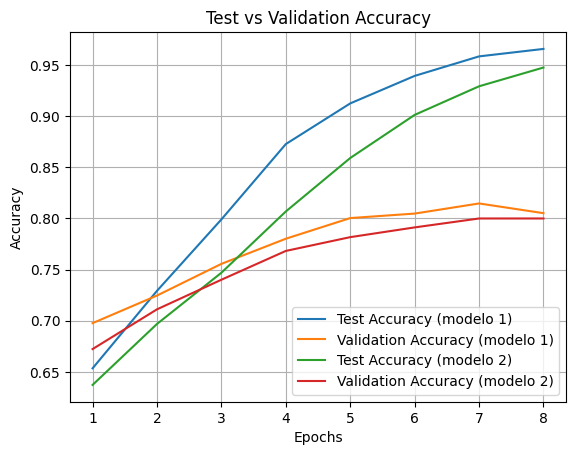

In [ ]:
plot_train_metrics_2(history2,history_double_fc_FT)

## Conclusiones

- Utilizando BERT y transfer learning se puede obtener un clasificador preciso rápidamente.
  - Además se parte de un pre-entrenamiento en un gran corpus de texto, utilizando atención bidireccional, lo que involucra una buena performance para compender el contexto de toda la reseña.
  - Como contrapartida BERT tiene una carga computacional mucho mayor que un modelo de clasificación sencillo.  

- Utilizando arquitecturas tipo transformers se puede tener un tamaño de contexto grande:
  - Esto resulta beneficioso para sentiment analysis, sobre todo si el contenido emocional depende de palabras o frases que estén separadas en la secuencia.

- Se puede apreciar que luego de realizar el fine tuning el modelo se ajusta mucho mejor al problema.

- En ambos modelos se aprecia un leve overfitting que podría solucionarse mediante alguna técnica de regularización o ajustando la probabilidad en las capas de dropout.

- A partir de las salidas de BERT se pueden agregar diferentes capas para obtener distintos resultados que se ajusten mejor a resolver el problema.
    - En este trabajo se probaron sólo dos modelos sencillos debido a los costos computacionales de entrenar los modelos. Se podría seguir iterando hasta obtener mejores resultados.

